# Classification with Tensorflow

let's build a classifier for tweet sentiment analysis using tensorflow.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

print(tf.__version__)

2.11.0


Let's import our tweet dataset, and make it only positive or negative tweets, no neutral

In [2]:
df = pd.read_csv('../datasets/tweets/AirlineTweets.csv')
df = df[['airline_sentiment', 'text']]
df = df[df['airline_sentiment'] != 'neutral'].copy()
target_map = {'positive': 1, 'negative': 0}
df['label'] = df['airline_sentiment'].map(target_map)
df.head()

,airline_sentiment,text,label
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


Now that our dataset it preprocessed, let's split it in training and test set, and vectorize the text using TD-IDF

In [3]:
max_features = 2000
df_train, df_test = train_test_split(df, random_state=42)
vectorizer = TfidfVectorizer(max_features=max_features)
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

# data must not be sparse matrix before passing into tensorflow
X_train = X_train.toarray()
X_test = X_test.toarray()

Y_train = np.array(df_train['label'])
Y_test = np.array(df_test['label'])

In [4]:
print('X_train: ', X_train.shape)
print('Y_train: ', Y_train.shape)

X_train:  (8655, 2000)
Y_train:  (8655,)


At this point we have our dataset fully ready. Now let's build our neural network.

In [5]:
# input dimensions
D = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(D,)),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2001      
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=Adam(learning_rate=0.01),
  metrics=[tf.keras.metrics.BinaryAccuracy()]
)

Now let's train the model

In [7]:
r = model.fit(
  X_train, Y_train,
  validation_data=(X_test, Y_test),
  epochs=40,
  batch_size=256,
)

Epoch 1/40


2023-05-12 00:00:12.043241: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


34/34 [==============================] - 0s 4ms/step - loss: 0.5504 - binary_accuracy: 0.7920 - val_loss: 0.4459 - val_binary_accuracy: 0.8049
Epoch 2/40
34/34 [==============================] - 0s 2ms/step - loss: 0.4223 - binary_accuracy: 0.7920 - val_loss: 0.3846 - val_binary_accuracy: 0.8053
Epoch 3/40
34/34 [==============================] - 0s 2ms/step - loss: 0.3742 - binary_accuracy: 0.7963 - val_loss: 0.3507 - val_binary_accuracy: 0.8181
Epoch 4/40
34/34 [==============================] - 0s 1ms/step - loss: 0.3394 - binary_accuracy: 0.8069 - val_loss: 0.3244 - val_binary_accuracy: 0.8288
Epoch 5/40
34/34 [==============================] - 0s 1ms/step - loss: 0.3116 - binary_accuracy: 0.8259 - val_loss: 0.3037 - val_binary_accuracy: 0.8406
Epoch 6/40
34/34 [==============================] - 0s 1ms/step - loss: 0.2891 - binary_accuracy: 0.8422 - val_loss: 0.2872 - val_binary_accuracy: 0.8527
Epoch 7/40
34/34 [==============================] - 0s 1ms/step - loss: 0.2704 - binary

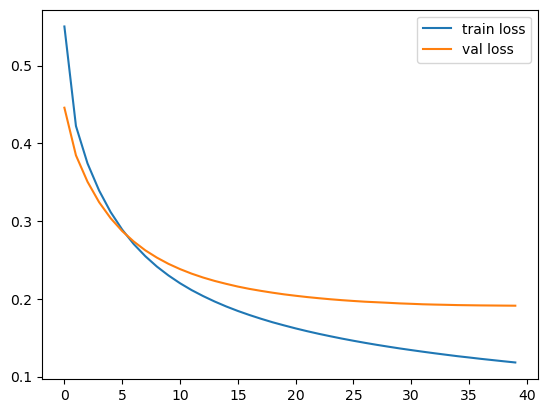

In [8]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();


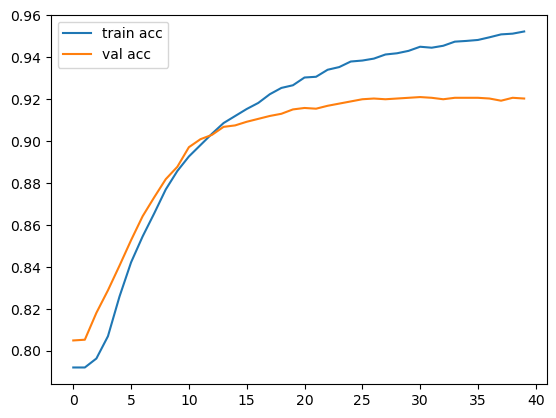

In [9]:
# Plot accuracy per iteration
plt.plot(r.history['binary_accuracy'], label='train acc')
plt.plot(r.history['val_binary_accuracy'], label='val acc')
plt.legend();

In [10]:
p = model.predict(X_train)
print(p)

271/271 [==============================] - 0s 338us/step
[[ 1.6837975]
 [-4.131456 ]
 [ 0.6547003]
 ...
 [ 1.359266 ]
 [-2.7364779]
 [-3.619324 ]]


In [11]:
P_train = ((model.predict(X_train) > 0) * 1.0).flatten()
P_test = ((model.predict(X_test) > 0) * 1.0).flatten()

91/91 [==============================] - 0s 328us/step


In [12]:
P_train

array([1., 0., 1., ..., 1., 0., 0.])

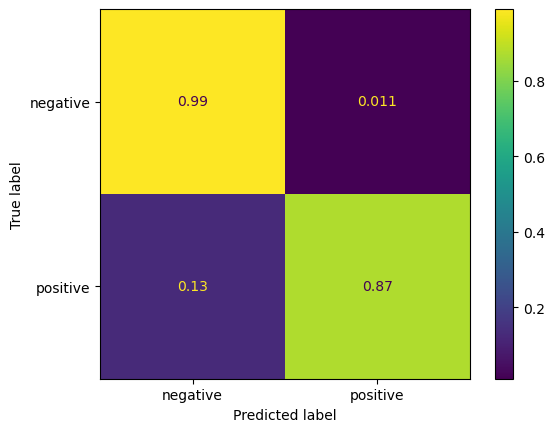

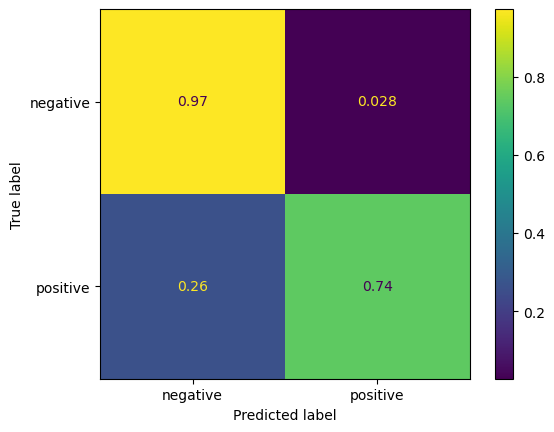

In [13]:
cm_train = confusion_matrix(Y_train, P_train, normalize='true')
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['negative', 'positive'])
disp_train.plot()
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['negative', 'positive'])
disp_test.plot()

# Multi-Class Text Classifier with TensorFlow

In [14]:
df = pd.read_csv('../datasets/bbc/bbc_text_cls.csv')

In [15]:
# map classes to integers from 0...K-1
df['targets'] = df['labels'].astype("category").cat.codes

In [16]:
df.head()

,text,labels,targets
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,0
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,0
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,0
3,High fuel prices hit BA's profits\n\nBritish A...,business,0
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,0


In [17]:
# split our dataset
df_train, df_test = train_test_split(df, test_size=0.2)

In [18]:
vectorizer = TfidfVectorizer(stop_words='english')
Xtrain = vectorizer.fit_transform(df_train['text'])
Xtest = vectorizer.transform(df_test['text'])

In [ ]:
# data must not be sparse matrix before passing into tensorflow
Xtrain = Xtrain.toarray()
Xtest = Xtest.toarray()

In [24]:
Ytrain = df_train['targets']
Ytest = df_test['targets']

In [20]:
# input dimension
D = Xtrain.shape[1]
# number of categories
K = df['targets'].max() + 1

In [93]:
# Build a ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(D,), activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(K),
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 32)                843456    
                                                                 
 dense_20 (Dense)            (None, 32)                1056      
                                                                 
 dense_21 (Dense)            (None, 5)                 165       
                                                                 
Total params: 844,677
Trainable params: 844,677
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

In [95]:
r = model.fit(
  Xtrain, Ytrain,
  validation_data=(Xtest, Ytest),
  epochs=25,
  batch_size=128,
)

Epoch 1/25
14/14 [==============================] - 0s 11ms/step - loss: 1.5729 - accuracy: 0.6612 - val_loss: 1.5062 - val_accuracy: 0.9281
Epoch 2/25
14/14 [==============================] - 0s 6ms/step - loss: 1.4062 - accuracy: 0.9404 - val_loss: 1.3175 - val_accuracy: 0.9348
Epoch 3/25
14/14 [==============================] - 0s 6ms/step - loss: 1.1499 - accuracy: 0.9730 - val_loss: 1.0643 - val_accuracy: 0.9506
Epoch 4/25
14/14 [==============================] - 0s 6ms/step - loss: 0.8401 - accuracy: 0.9843 - val_loss: 0.7861 - val_accuracy: 0.9461
Epoch 5/25
14/14 [==============================] - 0s 6ms/step - loss: 0.5450 - accuracy: 0.9927 - val_loss: 0.5468 - val_accuracy: 0.9618
Epoch 6/25
14/14 [==============================] - 0s 6ms/step - loss: 0.3253 - accuracy: 0.9989 - val_loss: 0.3776 - val_accuracy: 0.9753
Epoch 7/25
14/14 [==============================] - 0s 6ms/step - loss: 0.1879 - accuracy: 0.9989 - val_loss: 0.2719 - val_accuracy: 0.9798
Epoch 8/25
14/14 [=

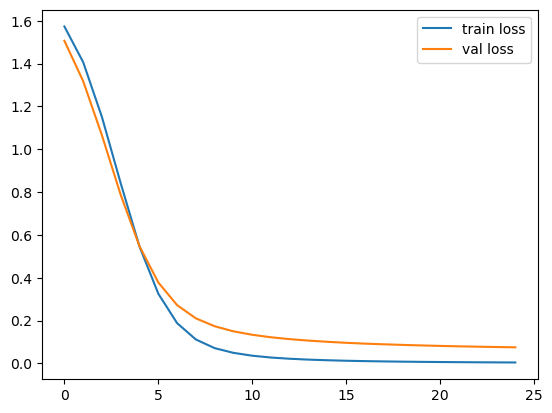

In [96]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

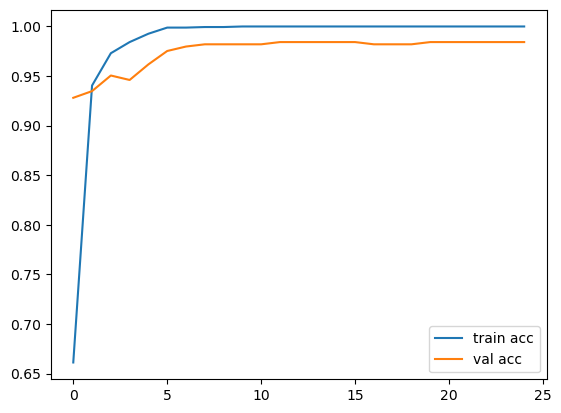

In [97]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();